# Computer Vision - Sign Language Recognition
---
## Task 7 - Model training

In [26]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping

## Data loading

Mounting my google drive to access the dataset and save the model. Change the PATH variables to work with your own directory.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pathlib
DS_PATH = "/content/drive/MyDrive/Colab Notebooks/Computer Vision/dataset"
data_dir = pathlib.Path(DS_PATH)

In [4]:
# Loading parameters
batch_size = 32
img_height = 224
img_width = 224
seed = 101
validation_prop = 0.2

LETTERS = ["A", "C", "I", "L"]

In [5]:
#load the training data
train_ds = image_dataset_from_directory(
  data_dir,
  validation_split=validation_prop,
  subset="training",
  seed=seed,
  image_size=(img_height, img_width),
  class_names=LETTERS,
  color_mode="grayscale",
  batch_size=batch_size)

#load the validation data
val_ds = image_dataset_from_directory(
  data_dir,
  validation_split=validation_prop,
  subset="validation",
  seed=seed,
  image_size=(img_height, img_width),
  class_names=LETTERS,
  color_mode="grayscale",
  batch_size=batch_size)


Found 392 files belonging to 4 classes.
Using 314 files for training.
Found 392 files belonging to 4 classes.
Using 78 files for validation.


Showing some images from the dataset to get an idea of our data.

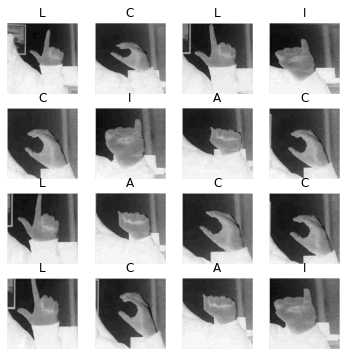

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
for images, labels in train_ds.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, 1+i)
    plt.imshow(images[i].numpy().astype('uint8').squeeze(), cmap=plt.cm.binary)
    plt.title(LETTERS[labels[i]])
    plt.axis('off')

## Model construction and training

Note: After experimenting a little bit with the topology of the network, it appears that it does not matter much: any CNN, as long as it is not ridiculously narrow or shallow, will reach a validation accuracy of 1 if given enough time. It is because of that conclusion that I decided to use an early_stopping callback approach.

In [36]:
model = Sequential([
  layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(img_height, img_width, 1), name="InputLayer"),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Dropout(0.2),
  layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Dropout(0.2),
  layers.GlobalAvgPool2D(),
  layers.Dense(128, activation='relu'),
  layers.Dense(4, name="OutputLayer")
])


In [37]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [38]:
# Train until the model is no longer getting better
early_stop = EarlyStopping(monitor="val_accuracy", patience=8, verbose=1, mode="max", restore_best_weights=True)

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=50,
  callbacks=early_stop
)

Epoch 1/50
10/10 [==============================] - 2s 87ms/step - loss: 5.8199 - accuracy: 0.2448 - val_loss: 1.7730 - val_accuracy: 0.2179
Epoch 2/50
10/10 [==============================] - 1s 65ms/step - loss: 1.7270 - accuracy: 0.2713 - val_loss: 1.4021 - val_accuracy: 0.2179
Epoch 3/50
10/10 [==============================] - 1s 65ms/step - loss: 1.4443 - accuracy: 0.2709 - val_loss: 1.4303 - val_accuracy: 0.2308
Epoch 4/50
10/10 [==============================] - 1s 66ms/step - loss: 1.3645 - accuracy: 0.3205 - val_loss: 1.3819 - val_accuracy: 0.2821
Epoch 5/50
10/10 [==============================] - 1s 66ms/step - loss: 1.3577 - accuracy: 0.3914 - val_loss: 1.2725 - val_accuracy: 0.2821
Epoch 6/50
10/10 [==============================] - 1s 66ms/step - loss: 1.2298 - accuracy: 0.4913 - val_loss: 1.0432 - val_accuracy: 0.6667
Epoch 7/50
10/10 [==============================] - 1s 67ms/step - loss: 0.9834 - accuracy: 0.6378 - val_loss: 0.7818 - val_accuracy: 0.6538
Epoch 8/50
10

In [39]:
model_json = model.to_json()
with open("/content/drive/MyDrive/Colab Notebooks/Computer Vision/model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("/content/drive/MyDrive/Colab Notebooks/Computer Vision/model_weights.h5")
print("Saved model to disk")

Saved model to disk


### Plots of the training process

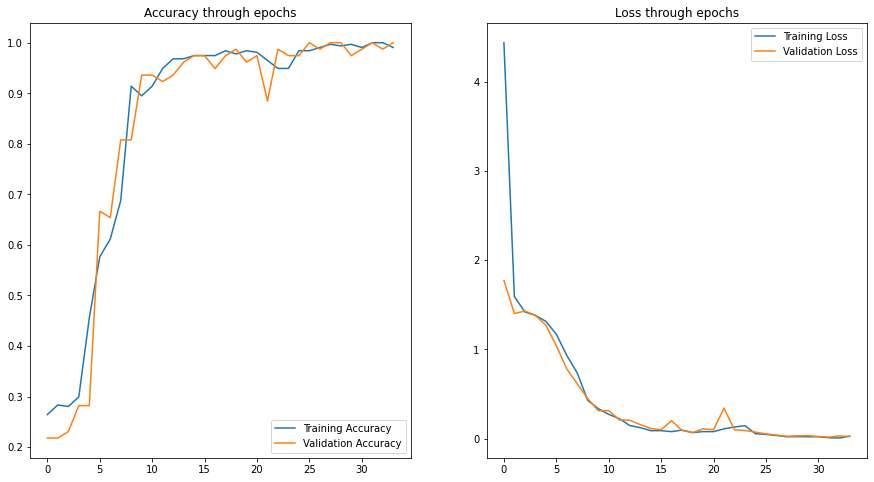

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy through epochs')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Loss through epochs')
plt.show()

## Task 8 - Test phase

For the sake of clarity and brevity, we use images from the test set to see if our model works. Indeed, taking new images would require us to add to this notebook the whole pipeline, with the camshift and image cropping and so on - and the results are exactly the same since test set images were taken in the same way as new images would be. (In real life, to deploy our model on new images, one would simply load the saved model at the start of a new notebook) 

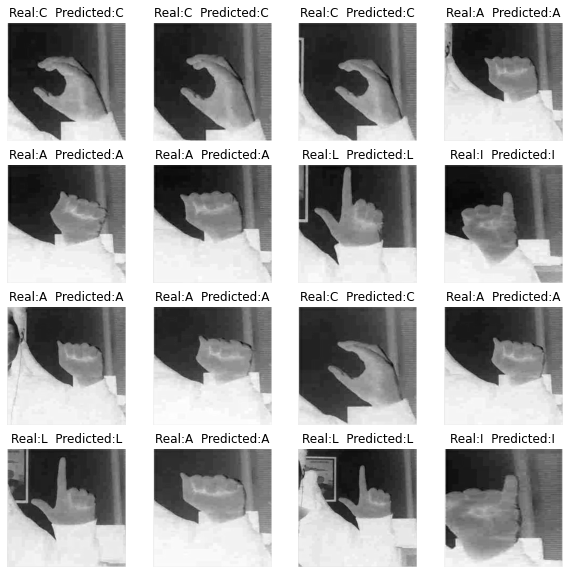

In [41]:
plt.figure(figsize=(10,10))
for images, labels in val_ds.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, 1+i)
    plt.imshow(images[i].numpy().astype('uint8').squeeze(), cmap=plt.cm.binary)
    current_img = tf.expand_dims(images[i], 0)
    pred = model.predict(current_img)
    pred_letter = LETTERS[np.argmax(pred)]
    plt.title(f"Real:{LETTERS[labels[i]]}  Predicted:{pred_letter}")
    plt.axis('off')